# Armadillo real world example - Frequentist fit

In progress

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [17]:
from pysip.regressors import Regressor
from pysip.statespace import TwTi_RoRi

In [18]:
# Load and prepare the data
df = pd.read_csv("../../../data/armadillo/armadillo_data_H2.csv").set_index("Time")
df.drop(df.index[-1], axis=0, inplace=True)
inputs = ["T_ext", "P_hea"]
outputs = "T_int"
sT = 3600.0 * 24.0
df.index /= sT  # Change time scale to days

In [19]:
# Parameter settings for second order dynamic thermal model
parameters = [
    dict(name="Ro", scale=1e-2, transform="log"),
    dict(name="Ri", scale=1e-3, transform="log"),
    dict(name="Cw", scale=1e7 / sT, transform="log"),
    dict(name="Ci", scale=1e6 / sT, transform="log"),
    dict(name="sigw_w", scale=1e-3 * sT**0.5, transform="log"),
    dict(name="sigw_i", value=0.0, transform="fixed"),
    dict(name="sigv", scale=1e-2, transform="log"),
    dict(name="x0_w", loc=25.0, scale=7.0, transform="none"),
    dict(name="x0_i", value=26.7, transform="fixed"),
    dict(name="sigx0_w", value=0.1, transform="fixed"),
    dict(name="sigx0_i", value=0.1, transform="fixed"),
]

In [20]:
# Instantiate the model and use the first order hold approximation
model = TwTi_RoRi(parameters, hold_order=1)
reg = Regressor(model, inputs=inputs, outputs=outputs)
fit_summary, corr_matrix, opt_summary = reg.fit(df=df)
fit_summary

Optimization terminated successfully.
         Current function value: -331.057569
         Iterations: 25
         Function evaluations: 510
         Gradient evaluations: 34


,θ,σ(θ),pvalue,|g(η)|,|dpen(θ)|
Ro,0.017593,0.000927,0.0,0.000022,3.230694e-17
Ri,0.001984,0.000075,0.0,0.000049,2.539865e-17
Cw,169.597112,7.662583,0.0,0.000023,4.657315e-17
Ci,18.946350,0.771580,0.0,0.000022,3.731826e-17
sigw_w,0.521344,0.046986,0.0,0.000007,3.178810e-17
sigv,0.034325,0.002333,0.0,0.000029,8.487470e-18
x0_w,26.594539,0.130517,0.0,0.000011,0.000000e+00


In [21]:
# Predict the indoor temperature each minute
dt = 60 / 3600
tnew = np.arange(df.index[0], df.index[-1], dt)
ds = reg.predict(df=df, tnew=tnew)
ym = ds["y_mean"].sel(outputs="T_int")
ysd = ds["y_std"].sel(outputs="T_int")

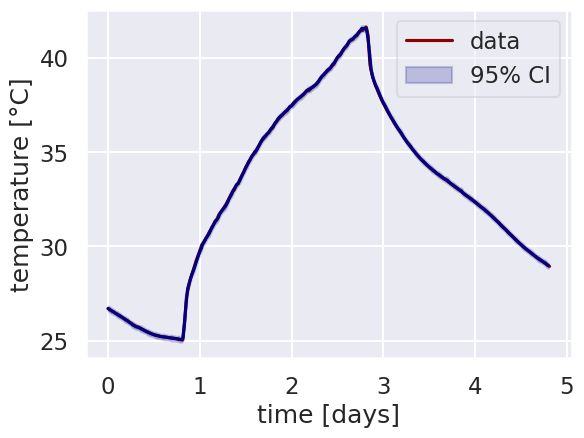

In [22]:
plt.plot(df.index, df["T_int"], color="darkred", label="data")
plt.plot(tnew, ym, color="navy")
plt.fill_between(
    tnew, ym - 2 * ysd, ym + 2 * ysd, color="darkblue", alpha=0.2, label=r"95% CI"
)
plt.xlabel("time [days]")
plt.ylabel("temperature [°C]")
plt.tight_layout()
plt.legend(loc="best", fancybox=True, framealpha=0.5)